<a href="https://colab.research.google.com/github/dTenebrae/neural_networks/blob/hw7/hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

### Обзор YOLOR

В мае 2021 года была <a href='https://arxiv.org/pdf/2105.04206v1.pdf'>опубликована</a> статья под названием:  
**You Only Learn One Representation: Unified Network for Multiple Tasks**

Изначальная идея статьи состоит в том, что авторы предлагают использовать для сети явные(explicit) и неявные(implicit) знания, по аналогии с принятием решений в человеческом мозге. Обосновывается это тем, что обычные сверточные сети хорошо выполняют только одну задачу, на которую они были натренированы, и слабо справляются с прочими.

*В теории нейросетей явными знаниями называют фичи, полученные с поверхностных(shallow) слоев сети, неявными, соответственно, с глубоких(deep)*

В данной работе, явными называют знания, прямо относящиеся к наблюдению, а не относящиеся - неявными.
  
![](https://miro.medium.com/max/4800/0*VyNEx1UNgqWY2_vp)
  
Общая идея следующая:

Создать объединенную сеть для решения широкого спектра задач, которая обучается общему представлению через объединение явных и неявных знаний. Это поможет улучшить показатели сетей (для которых осуществяется такая модификация) за счет небольшого увеличения числа обучаемых параметров и, как следствие затрат на обучение нейронки.
Эта сеть, за счет создания в обученной модели общего представления, может выделять под-представления для решения различных задач. 

### **Как работают неявные знания (implicit knowledge)**

Так как неявное представление $z_i$ не связано с наблюдением, можно представить его как константный тензор $Z = \{z_1, z_2, ..., z_k\}$

Далее снижаем размерность с помощью **Manifold space reduction** (технически это dot вектора $Z$ на вектора проекции)

**Kernel space alignment**   
Так как задача у этой сети - генерализация под многие возможные цели, возникает проблема несовпадения (misalignment) в multihead нейронках. Другими словами, так как на выходе у нас стоят разные сети, то в результате они одни и те же объекты могут раположить в скрытом состоянии сильно по разному. Вывод - требуется нечто вроде нормализации, которое авторами решено через сложение и умножение выхода с этих сетей на тензор неявного представления $z$, после чего это скармливается еще одной нейронке, которая приводит это к единообразию.

Или

Пусть,  
$X$ - входные данные  
$f_{\theta}$ - некая входная нейронная сеть  
$f_{\phi_1}, f_{\phi_2}$ - выходные нейросети  
$z_1, z_2$ - тензоры неявных представлений  
$g_{\epsilon_1}, g_{\epsilon_2}$ - нормирующие нейросети  

Тогда, 

В случае объединения результатов $ f_{\phi_1}(f_{\theta}(X)) $ и $ f_{\phi_2}(f_{\theta}(X)) $ в пространстве признаков классы получатся на большом расстоянии друг от друга даже при условии принадлежности к одному и тому же.

Если же мы добавим нормирующие слагаемые $g_{\epsilon_1}(z_1)$ и $g_{\epsilon_2}(z_2)$, или $$ f_{\phi_1}(f_{\theta}(X))+g_{\epsilon_1}(z_1) $$ и $$ f_{\phi_2}(f_{\theta}(X))+g_{\epsilon_2}(z_2) $$  

то мы добьемся желаемого единообразия.

Эта методика может широко применяться во многих областях, например в сетях FPN(Feature Piramid Network) для соотнесения больших и малых объектов.

**Больше функций**

Тензор неявных знаний может быть использован во многих случаях, например:  

- предсказание смещения от центра координат
- улучшение рамки детектора
- выбор важных фичей за счет различных операций (как то, умножение, сложение, конкатенация и т.п.)

В общем, основная идея в том, что мы можем использовать полученные ранее знания нейронной сети, обученной на, казалось бы, нерелевантном к текущему объекту данных, в очень многих случаях.
___
### Суммирую

Если процесс обучения обычной сети можно представить, как  

$$ y = f_{\theta}(x) + \epsilon; \epsilon \to min $$

то процесс обучения объединенной сети выглядит как  

$$ y = f_{\theta}(x) + \epsilon + g_{\phi}(\epsilon_{ex}(x),\epsilon_{im}(z)); \epsilon + g_{\phi}(\epsilon_{ex}(x),\epsilon_{im}(z)) \to min $$

где  
$\epsilon_{ex}, \epsilon_{im}$ - операторы, моделирующие ошибку явную и неявную от наблюдений $x$ и латентного состояния $z$  
$g_{\phi}$ - функция зависящая от задачи, решаемой сетью  
___
### Итого 
Плюсы:
- БОльшая точность на одноуровневых сетях (one stage)
- Возможность использования одной архитектуры под разные задачи
- Достаточно легкая модернизация уже имеющихся архитектур

Минусы:  
- Добавляется некоторое количество тренируемых параметров  
- Появляется необходимость дополнительного обучения
- Как следствие возрастают затраты на обучение (хотя и незначительно, если верить авторам)


2. Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

In [ ]:
import tensorflow_hub as hub
import cv2
import urllib.request as rq
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
def url_to_image(url):
    resp = rq.urlopen(url)
    img = np.asarray(bytearray(resp.read()),dtype="uint8")
    img = cv2.imdecode(img,cv2.IMREAD_COLOR)

    return img

In [ ]:
width = 1028
height = 1028

In [ ]:
# Загружаем модель с хаба (EfficientDet-Lite2)
detector = hub.load("https://tfhub.dev/tensorflow/efficientdet/lite2/detection/1")

# Метки классов
labels = pd.read_csv('./drive/MyDrive/csv/labels.csv', sep=';', index_col='ID')
labels = labels['OBJECT (2017 REL.)']
print(f"Количество классов: {len(labels)}")

Количество классов: 91


In [ ]:
# Берем случайную картинку
# img = url_to_image('https://picsum.photos/1028/1028?random=1')

img = url_to_image('https://lh3.googleusercontent.com/vq9TCQUVTSu27j_tY_xuokKSPGEhvmzAkdO4e3IcTRTzw1Zijm_2REc77IFJvo53GARnpjFgWTnnmJ8tM5ZvVVzDQ1QcLNA0ZzOTnmtbfYeAPtMrcO9mbveC7LvX7RejRFvyoFVvXnPIbXV5Ctl8pQWOW42kXYNUKd6a-jrA_QRthLUcO-40Q7ULRqrVuIc6gfaT_GOShyfI6TfktwogzgjGLlNv3cv5seCT15slyQac9oso7JfIx49NzuaebJwzqq-TveH1NXrZHx23pV7Vm3LUv6XBVE-7Xvi84xb3ub-2UHWgh_0TMPmTNAq7k1riaM44g9tTvOVi4kszeYLE0-TdiKIJwaKQGBBMqNsr8jEpeyXTT5uX9vJwf9pPplf34zHC5XE0BrkeAvseGXoEq0cDjzidB56V9_vZxs7sm8l-ipyuR0sXVXijCWzvgGAVoUI8FlQYk9jLadPsmExyDyX6e-UVCTNHlyAm3JQmflCR2E4eoUX7B-0sBsCk_LxiW4DNG-S0_gJ4DmjM-EYgWy-K2j9ZNT8RgOy32Nm4gBQQsoGVS8TF3YIl07GfOZwtQ5Pg8dEIqYyr6Jx_iv6_LDZEH_lA3qve6QmSyjTlsohQG8y5oWr7R-Ywrzj27DNHRrrx_qG_Vo7m_wFB7ujwW6Xrr4RqISBEf8wv0_S97bglb4C3Ix8t6Rs9ADyqOqJKZOz5-u2GAkmE3Lhkqj2z-GFW=w2060-h1544-no?authuser=0')

#Preprocessing
inp = cv2.resize(img, (width , height ))
rgb = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)
rgb_tensor = tf.convert_to_tensor(rgb, dtype=tf.uint8)
rgb_tensor = tf.expand_dims(rgb_tensor , 0)

100 объектов

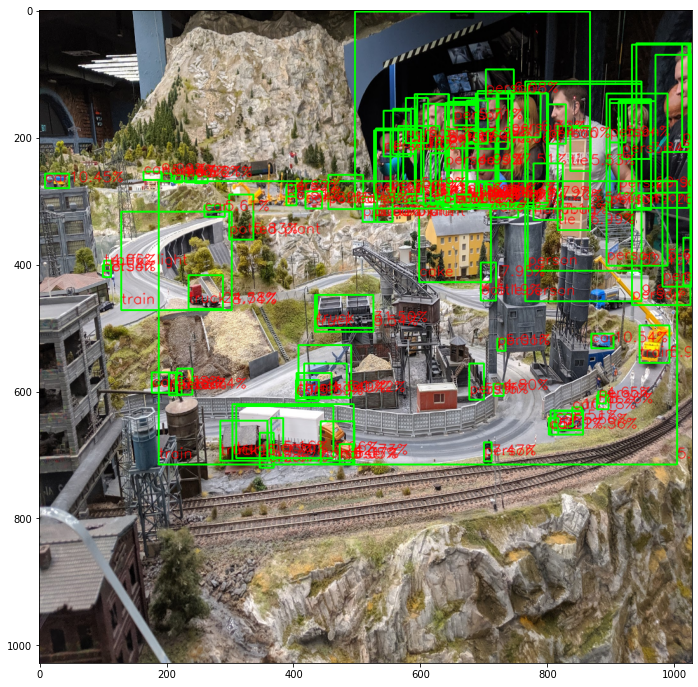

In [ ]:
plt.figure(figsize=(12,12))

# Вероятность, при которой будем отображать объект
CERTAINTY = 0.0
# Предсказания
boxes, scores, classes, num_detections = detector(rgb_tensor)
exists = np.sum(scores >= CERTAINTY)

if exists:
    # Processing outputs
    pred_labels = classes.numpy().astype('int')[0] 
    pred_labels = [labels[i] for i in pred_labels]
    pred_boxes = boxes.numpy()[0].astype('int')
    pred_scores = scores.numpy()[0]

    # Рисуем метки и рамки на изображениее
    for score, (ymin, xmin, ymax, xmax), label in zip(pred_scores, pred_boxes, pred_labels):
        if score < CERTAINTY:
            continue

        score_txt = f'{100 * score:.2f}%'
        img_boxes = cv2.rectangle(rgb,(xmin, ymax),(xmax, ymin),(0,255,0),2)      
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img_boxes, label,(xmin, ymax-10), font, 0.75, (255,0,0), 1, cv2.LINE_AA)
        cv2.putText(img_boxes,score_txt,(xmax , ymax-10), font, 0.75, (255,0,0), 1, cv2.LINE_AA)
    plt.imshow(img_boxes);
else:
    print('Nothing found')

10 объектов

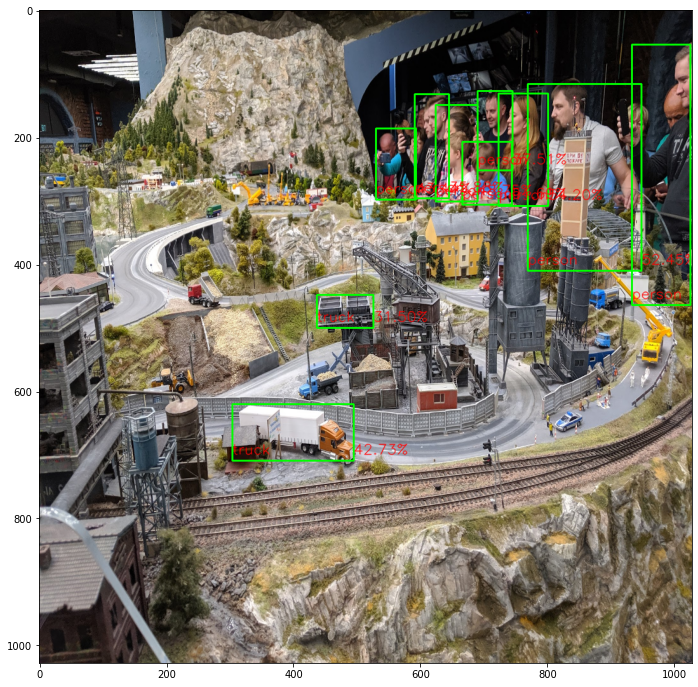

In [ ]:
plt.figure(figsize=(12,12))

# Вероятность, при которой будем отображать объект
CERTAINTY = 0.3
# Предсказания
boxes, scores, classes, num_detections = detector(rgb_tensor)
exists = np.sum(scores >= CERTAINTY)

if exists:
    # Processing outputs
    pred_labels = classes.numpy().astype('int')[0] 
    pred_labels = [labels[i] for i in pred_labels]
    pred_boxes = boxes.numpy()[0].astype('int')
    pred_scores = scores.numpy()[0]

    # Рисуем метки и рамки на изображении
    for score, (ymin, xmin, ymax, xmax), label in zip(pred_scores, pred_boxes, pred_labels):
        if score < CERTAINTY:
            continue

        score_txt = f'{100 * score:.2f}%'
        img_boxes = cv2.rectangle(rgb,(xmin, ymax),(xmax, ymin),(0,255,0),2)      
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img_boxes, label,(xmin, ymax-10), font, 0.75, (255,0,0), 1, cv2.LINE_AA)
        cv2.putText(img_boxes,score_txt,(xmax , ymax-10), font, 0.75, (255,0,0), 1, cv2.LINE_AA)
    plt.imshow(img_boxes);
else:
    print('Nothing found')

Оригинальное изображение

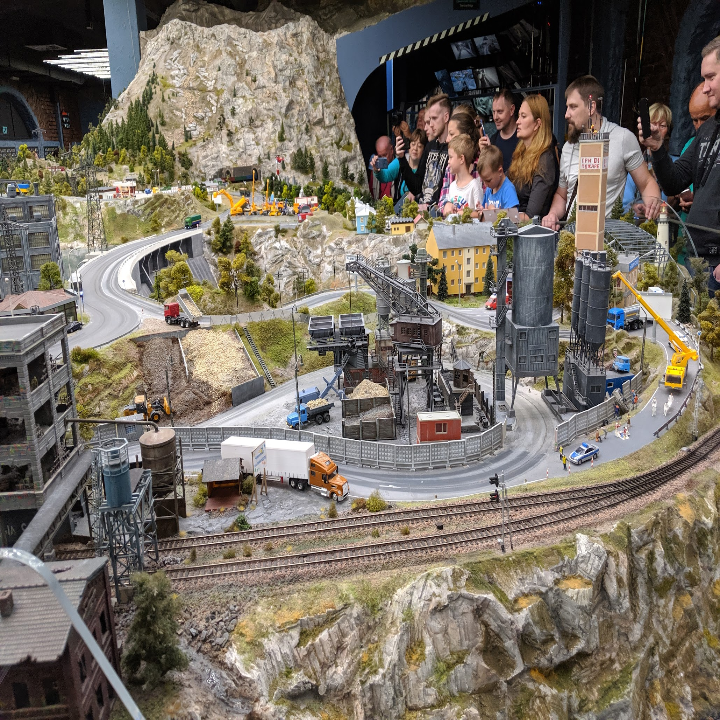

In [ ]:
img_resized = cv2.resize(img, (720 , 720 ))
cv2_imshow(img_resized);

3. Ссылка на репозиторий с полным кодом для обучения ssd нейросети - https://github.com/sergeyveneckiy/ssd-tensorflow. Попробуйте улучшить точность ее работы и напишите отчет, что вы пробовали изменить в ее параметрах и как это отражалось на процессе обучения нейронной сети.  
Обратите внимание! Мин. сист. требования для запуска данного проекта - это минимум 8 Gb ОЗУ. Если у вас недостаточно мощности компьютера, то вы можете просто изучить содержимое исходного кода и датасета данного проекта.


К сожалению на рабочей машине запустить не получилось, в колабе работает через пень-колоду (то тренируется, то выдает NaN в лоссе). Итого - не успел.